<a href="https://colab.research.google.com/github/Starksood/Experimental_Conundrums/blob/main/TheFunctionalAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*The functional API*

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers.

In [6]:
inputs = keras.Input(shape=(784,))
inputs.shape

TensorShape([None, 784])

In [7]:
inputs.dtype

tf.float32

In [8]:
dense = layers.Dense(64, activation="relu")
x = dense(inputs)

The "layer call" action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get x as the output.

Let's add a few more layers to the graph of layers:

In [10]:
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

In [11]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

In [13]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________


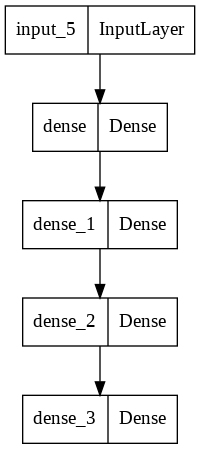

In [14]:
keras.utils.plot_model(model, "my_first_model.png")

This figure and the code are almost identical. In the code version, the connection arrows are replaced by the call operation.

A "graph of layers" is an intuitive mental image for a deep learning model, and the functional API is a way to create models that closely mirrors this.



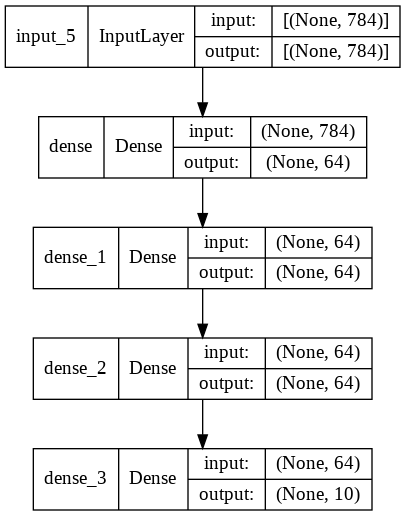

In [17]:
keras.utils.plot_model(model, "shape_info.png", show_shapes=True)


*Training, evaluation, and inference*

The Model class offers a built-in training loop (the fit() method) and a built-in evaluation loop (the evaluate() method). Note that you can easily customize these loops to implement training routines beyond supervised learning (e.g. GANs).

Here, load the MNIST image data, reshape it into vectors, fit the model on the data (while monitoring performance on a validation split), then evaluate the model on the test data:

In [18]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)
history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("test loss:", test_scores[0])
print("test accuracy:", test_scores[1])

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/2
750/750 [==============================] - 4s 4ms/step - loss: 0.3442 - accuracy: 0.8994 - val_loss: 0.1759 - val_accuracy: 0.9508
Epoch 2/2
750/750 [==============================] - 3s 3ms/step - loss: 0.1510 - accuracy: 0.9544 - val_loss: 0.1301 - val_accuracy: 0.9617
313/313 - 0s - loss: 0.1226 - accuracy: 0.9622 - 347ms/epoch - 1ms/step
test loss: 0.1225665882229805
test accuracy: 0.9621999859809875


*save and serialize*

In [19]:
model.save("FunctionalAPI")
del model
#Recreate the exact same model purely from the file:
#model = keras.models.load_model("model")

INFO:tensorflow:Assets written to: FunctionalAPI/assets


Use the same graph of layers to define multiple models


In the example below, you use the same stack of layers to instantiate two models: an encoder model that turns image inputs into 16-dimensional vectors, and an end-to-end autoencoder model for training.

In [25]:
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPool2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPool2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 6, 32)          9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 16)          4624      
                                                           

Here, the decoding architecture is strictly symmetrical to the encoding architecture, so the output shape is the same as the input shape (28, 28, 1).

The reverse of a Conv2D layer is a Conv2DTranspose layer, and the reverse of a MaxPooling2D layer is an UpSampling2D layer.



You can treat any model as if it were a layer by invoking it on an Input or on the output of another layer. By calling a model you aren't just reusing the architecture of the model, you're also reusing its weights.

To see this in action, here's a different take on the autoencoder example that creates an encoder model, a decoder model, and chains them in two calls to obtain the autoencoder model:

In [26]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 6, 6, 32)          9248      
                                                                 
 conv2d_15 (Conv2D)          (None, 4, 4, 16)          4624      
                                                           

As you can see, the model can be nested: a model can contain sub-models (since a model is just like a layer). A common use case for model nesting is ensembling. For example, here's how to ensemble a set of models into a single model that averages their predictions:

In [27]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

*Manipulate complex graph topologies
Models with multiple inputs and outputs*

For example, if you're building a system for ranking customer issue tickets by priority and routing them to the correct department, then the model will have three inputs:

the title of the ticket (text input),
the text body of the ticket (text input), and
any tags added by the user (categorical input)
This model will have two outputs:

the priority score between 0 and 1 (scalar sigmoid output), and
the department that should handle the ticket (softmax output over the set of departments).
You can build this model in a few lines with the functional API:

In [28]:
num_tags = 12 #Number of unique issue tags
num_words = 10000 #Size of vocab obtained when preprocessing the text data
num_departments = 4 #Number of departments 

title_input = keras.Input(
    shape=(None,), name="title"
) #variable-length sequence of ints

body_input = keras.Input(shape=(None,), name="body") #Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
) #binary vectors of size num_tags

#embed each word in the title into a 64 dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
#embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

#reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
#reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

#merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

#Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
#Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

#Instantiate an end to end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
    )

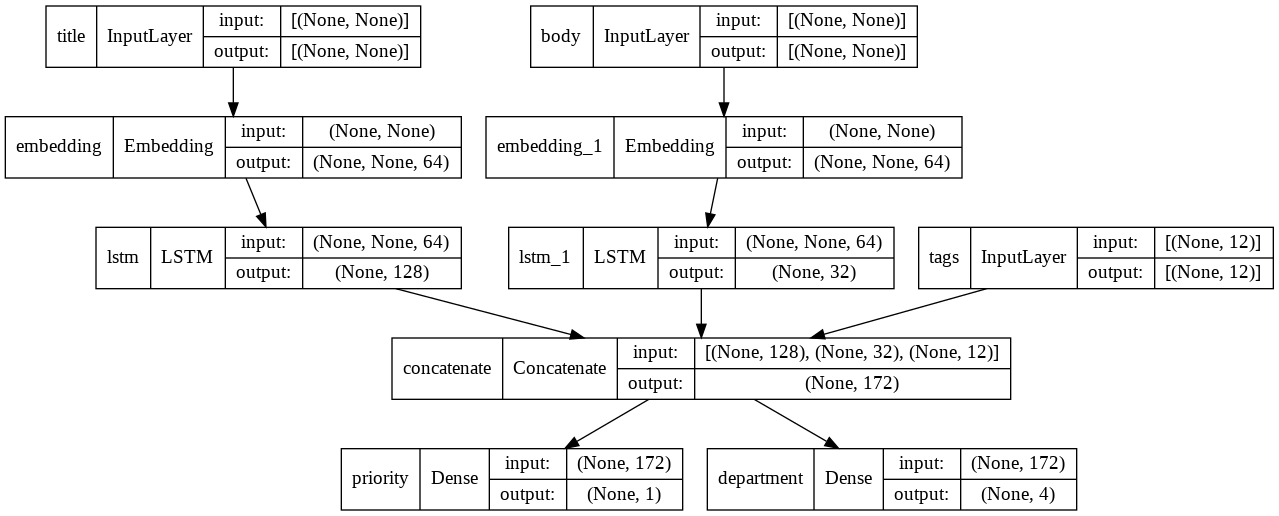

In [29]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

When compiling this model, you can assign different losses to each output. You can even assign different weights to each loss -- to modulate their contribution to the total training loss.

In [30]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

Since the output layers have different names, you could also specify the losses and loss weights with the corresponding layer names:

In [31]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights={"priority": 1.0, "department": 0.2},
)


Train the model by passing lists of NumPy arrays of inputs and targets:

In [32]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 [==============================] - 6s 49ms/step - loss: 1.2951 - priority_loss: 0.7032 - department_loss: 2.9598
Epoch 2/2
40/40 [==============================] - 2s 48ms/step - loss: 1.2867 - priority_loss: 0.6981 - department_loss: 2.9429


When calling fit with a Dataset object, it should yield either a tuple of lists like ([title_data, body_data, tags_data], [priority_targets, dept_targets]) or a tuple of dictionaries like ({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets}).

*A toy ResNet Model*

In addition to models with multiple inputs and outputs, the functional API makes it easy to manipulate non-linear connectivity topologies -- these are models with layers that are not connected sequentially

In [33]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()


Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 30, 30, 32)   896         ['img[0][0]']                    
                                                                                                  
 conv2d_17 (Conv2D)             (None, 28, 28, 64)   18496       ['conv2d_16[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 9, 9, 64)    0           ['conv2d_17[0][0]']              
                                                                                         

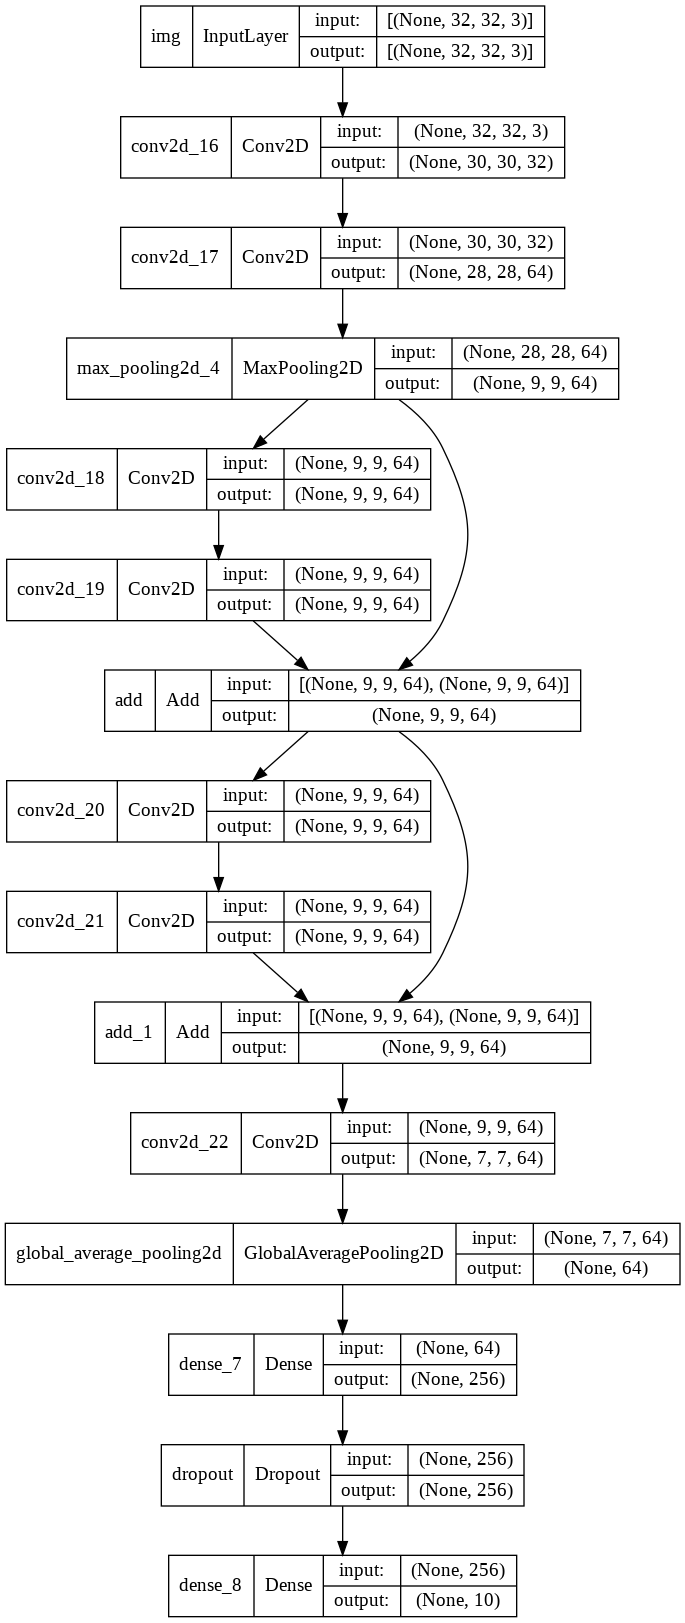

In [34]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

In [35]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# We restrict the data to the first 1000 samples so as to limit execution time
# on Colab. Try to train on the entire dataset until convergence!
model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=1, validation_split=0.2)

13/13 [==============================] - 6s 322ms/step - loss: 2.3148 - acc: 0.1025 - val_loss: 2.2944 - val_acc: 0.1350


*Shared layers*

Shared layers are often used to encode inputs from similar spaces (say, two different pieces of text that feature similar vocabulary). They enable sharing of information across these different inputs, and they make it possible to train such a model on less data. If a given word is seen in one of the inputs, that will benefit the processing of all inputs that pass through the shared layer.

To share a layer in the functional API, call the same layer instance multiple times. For instance, here's an Embedding layer shared across two different text inputs:

In [36]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

Extract and reuse nodes in the graph of layers
Because the graph of layers you are manipulating is a static data structure, it can be accessed and inspected. And this is how you are able to plot functional models as images.

This also means that you can access the activations of intermediate layers ("nodes" in the graph) and reuse them elsewhere -- which is very useful for something like feature extraction.

Let's look at an example. This is a VGG19 model with weights pretrained on ImageNet:


And these are the intermediate activations of the model, obtained by querying the graph data structure:


Use these features to create a new feature-extraction model that returns the values of the intermediate layer activations:


This comes in handy for tasks like neural style transfer, among other things.



In [ ]:
vgg19 = tf.keras.applications.VGG19()

In [ ]:
features_list = [layer.output for layer in vgg19.layers]

In [ ]:
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)

Extend the API using custom layers
tf.keras includes a wide range of built-in layers, for example:

Convolutional layers: Conv1D, Conv2D, Conv3D, Conv2DTranspose
Pooling layers: MaxPooling1D, MaxPooling2D, MaxPooling3D, AveragePooling1D
RNN layers: GRU, LSTM, ConvLSTM2D
BatchNormalization, Dropout, Embedding, etc.
But if you don't find what you need, it's easy to extend the API by creating your own layers. All layers subclass the Layer class and implement:

call method, that specifies the computation done by the layer.
build method, that creates the weights of the layer (this is just a style convention since you can create weights in __init__, as well).
To learn more about creating layers from scratch, read custom layers and models guide.

The following is a basic implementation of tf.keras.layers.Dense:

In [ ]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)


For serialization support in your custom layer, define a get_config method that returns the constructor arguments of the layer instance:

In [ ]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)
config = model.get_config()

new_model = keras.Model.from_config(config, custom_objects={"CustomDense": CustomDense})

Optionally, implement the class method from_config(cls, config) which is used when recreating a layer instance given its config dictionary. The default implementation of from_config is:




In [ ]:
def from_config(cls, config):
  return cls(**config)

Here's a quick example of a custom RNN, written from scratch, being used in a functional model:

In [ ]:
units = 32
timesteps = 10
input_dim = 5
batch_size = 16


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        self.classifier = layers.Dense(1)

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        return self.classifier(features)


# Note that you specify a static batch size for the inputs with the `batch_shape`
# arg, because the inner computation of `CustomRNN` requires a static batch size
# (when you create the `state` zeros tensor).
inputs = keras.Input(batch_shape=(batch_size, timesteps, input_dim))
x = layers.Conv1D(32, 3)(inputs)
outputs = CustomRNN()(x)

model = keras.Model(inputs, outputs)

rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, 10, 5)))